## Load data

In [1]:
import torch
from torch.utils.data import DataLoader
from core.dataloaders.playing_cards import PlayingCardDataset
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
torch.cuda.synchronize()

train_data_dir = r"./datasets/playing_cards/train"
valid_data_dir = r"./datasets/playing_cards/valid"
test_data_dir = r"./datasets/playing_cards/test"

cuda


In [2]:
# setting up transformation
transformation = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
type(transformation)

torchvision.transforms.transforms.Compose

In [3]:
# creating dataset
train_dataset = PlayingCardDataset(
    data_dir=train_data_dir,
    transform=transformation
)
valid_dataset = PlayingCardDataset(
    data_dir=valid_data_dir,
    transform=transformation
)
test_dataset = PlayingCardDataset(
    data_dir=test_data_dir,
    transform=transformation
)

classes = train_dataset.classes
print(classes)

['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']


training set 7624
valid set 265
test set 265
shapes:
torch.Size([128, 3, 128, 128])
torch.Size([128])


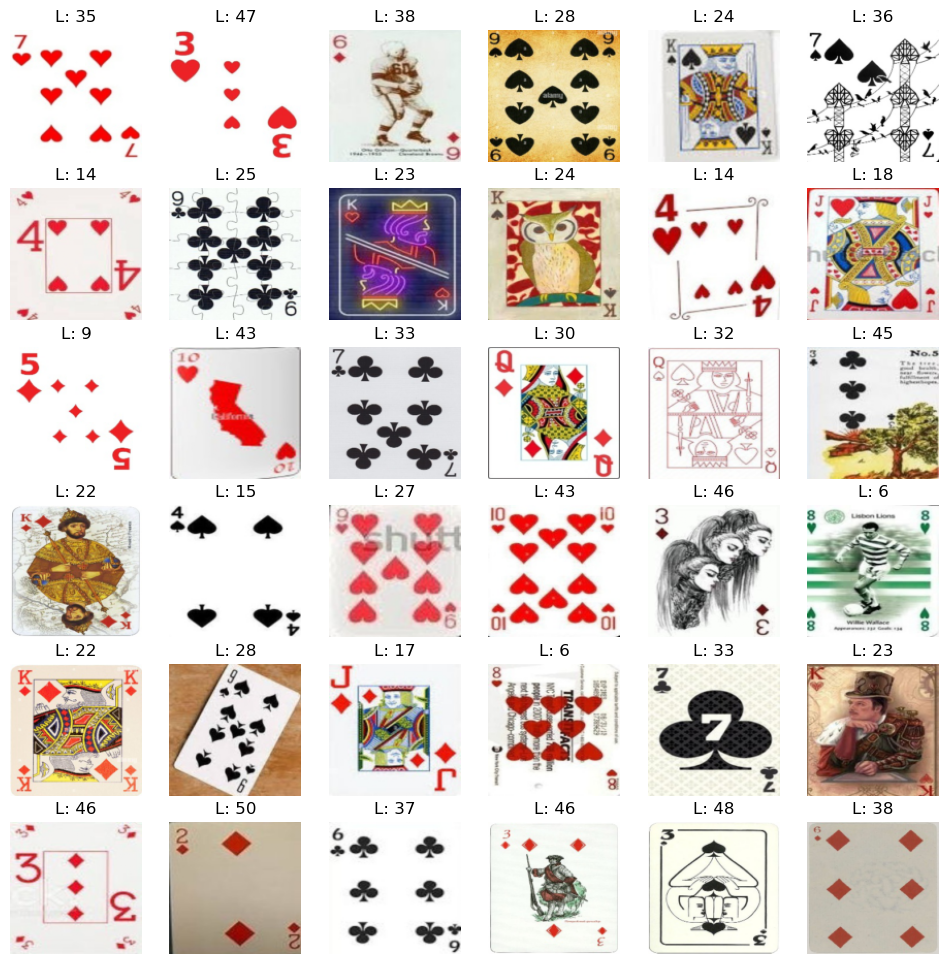

In [4]:
from shared_modules.display_engine import DisplayImages

# creating dataloader
workers = 8
prefetch = workers * 12
train_dataloader = DataLoader(train_dataset,
                              batch_size=32*4,
                              shuffle=True,
                              num_workers=workers,
                              pin_memory=True,
                              prefetch_factor=prefetch,
                              persistent_workers=True)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=32,
                              shuffle=False,
                              num_workers=workers,
                              pin_memory=True,
                              prefetch_factor=prefetch,
                              persistent_workers=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=workers,
                             pin_memory=True,
                             prefetch_factor=prefetch,
                             persistent_workers=True)

print("training set", len(train_dataloader.dataset))
print("valid set", len(valid_dataloader.dataset))
print("test set", len(test_dataloader.dataset))

# iterating over the dataset
for _, (image, label) in enumerate(train_dataloader):
    print("shapes:")
    print(image.shape)
    print(label.shape)
    break

DisplayImages.display_image(image, label)

In [ ]:
from tqdm import tqdm
nb_samples = len(train_dataloader.dataset)
for x_data, labels in tqdm(train_dataloader):
    x_data = x_data.to("cuda", non_blocking=True)
    labels = labels.to("cuda", non_blocking=True)
    pass

## Model

In [5]:
from core.classifier_models.efficientnet_b0_pretrained import SimpleCardClassifierEfNetb0
from torchinfo import summary
# generate model
model = SimpleCardClassifierEfNetb0(num_classes=53, pretrained = True)

In [6]:
# create optimizer and loss function
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# create wrapper
from core.wrappers.wrapper import Wrapper
classifier = Wrapper(model = model, optimizer= optimizer, criterion= criterion, device = device)

In [8]:
input_size = image.shape
summary(model=classifier.model,
        input_size=input_size,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
SimpleCardClassifierEfNetb0 (SimpleCardClassifierEfNetb0)    [128, 3, 128, 128]   [128, 53]            1,281,000            True
├─Sequential (features)                                      [128, 3, 128, 128]   [128, 1280]          --                   True
│    └─Conv2d (0)                                            [128, 3, 128, 128]   [128, 32, 64, 64]    864                  True
│    └─BatchNormAct2d (1)                                    [128, 32, 64, 64]    [128, 32, 64, 64]    64                   True
│    │    └─Identity (drop)                                  [128, 32, 64, 64]    [128, 32, 64, 64]    --                   --
│    │    └─SiLU (act)                                       [128, 32, 64, 64]    [128, 32, 64, 64]    --                   --
│    └─Sequential (2)                                        [128, 32, 64, 64]    [128, 320, 4, 

[14, 38, 42, 14, 14, 14, 12, 1, 10, 14, 14, 14, 22, 22, 10, 27, 2, 48, 5, 11, 1, 1, 35, 40, 1, 36, 8, 17, 1, 22, 36, 10, 49, 17, 1, 10, 23, 1, 1, 8, 10, 22, 27, 27, 22, 10, 36, 22, 20, 10, 1, 36, 36, 22, 10, 27, 14, 10, 1, 30, 22, 1, 10, 22, 36, 14, 51, 1, 8, 1, 21, 13, 17, 1, 36, 36, 22, 21, 1, 0, 40, 8, 14, 10, 14, 10, 12, 8, 48, 33, 8, 30, 10, 14, 33, 14, 14, 0, 8, 14, 14, 10, 46, 14, 0, 10, 14, 33, 10, 14, 12, 17, 18, 14, 14, 10, 14, 12, 14, 10, 40, 0, 14, 10, 10, 1, 22, 22, 8, 43, 36, 22, 14, 11, 30, 14, 13, 1, 10, 13, 36, 21, 22, 1, 14, 8, 10, 33, 14, 14, 8, 10, 14, 14, 33, 10, 10, 14, 2, 10, 33, 10, 14, 0, 14, 27, 22, 10, 40, 22, 8, 10, 8, 17, 8, 36, 1, 10, 13, 10, 27, 36, 1, 13, 44, 12, 30, 1, 10, 38, 10, 8, 17, 8, 41, 7, 8, 23, 10, 17, 1, 27, 10, 1, 10, 1, 22, 1, 43, 1, 43, 46, 8, 10, 22, 13, 46, 13, 14, 13, 27, 1, 22, 14, 21, 14, 1, 1, 5, 36, 10, 14, 10, 49, 1, 14, 22, 21, 10, 11, 14, 14, 14, 14, 14, 10, 27, 14, 14, 14, 22, 22, 14, 24, 17, 10, 10, 36, 22, 22, 14, 27, 30, 21, 

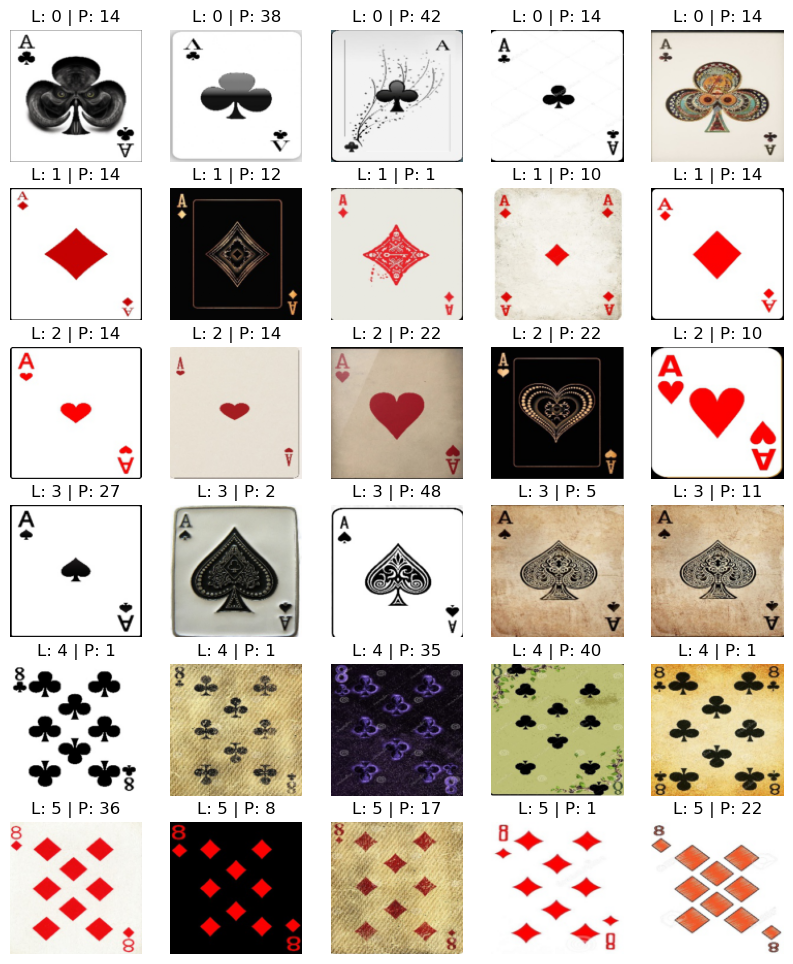

In [9]:
# model accuracy pre training
predictions = classifier.predict(test_dataloader)
print(predictions)
loss, acc = classifier.evaluate(test_dataloader)
print(loss, acc)

for _, (image, label) in enumerate(test_dataloader):
    break
    
DisplayImages.display_image(image, label, predictions, 6, 5)

## Training

In [10]:
num_epochs = 5
classifier.fit(epochs=num_epochs, train_dataloader = train_dataloader, valid_dataloader=valid_dataloader)

Epochs::  20%|██        | 1/5 [00:10<00:43, 10.83s/it]

| Epoch 1/5 | T-loss: 1.833 | V-loss: 0.551 |T-acc: 0.51 |V-acc: 0.82


Epochs::  40%|████      | 2/5 [00:16<00:23,  7.93s/it]

| Epoch 2/5 | T-loss: 0.510 | V-loss: 0.270 |T-acc: 0.85 |V-acc: 0.93


Epochs::  60%|██████    | 3/5 [00:22<00:13,  7.00s/it]

| Epoch 3/5 | T-loss: 0.234 | V-loss: 0.176 |T-acc: 0.93 |V-acc: 0.95


Epochs::  80%|████████  | 4/5 [00:28<00:06,  6.58s/it]

| Epoch 4/5 | T-loss: 0.143 | V-loss: 0.210 |T-acc: 0.96 |V-acc: 0.95


Epochs:: 100%|██████████| 5/5 [00:34<00:00,  6.93s/it]

| Epoch 5/5 | T-loss: 0.095 | V-loss: 0.154 |T-acc: 0.97 |V-acc: 0.94


In [ ]:
# model accuracy post training
predictions = classifier.predict(test_dataloader)
print(predictions)
loss, acc = classifier.evaluate(test_dataloader)
print(loss, acc)

for _, (image, label) in enumerate(test_dataloader):
    break

DisplayImages.display_image(image, label, predictions, 6, 5)

In [ ]:
from shared_modules.display_engine import DisplayMetrics

DisplayMetrics.display_metrics(classifier.train_losses,
                               classifier.val_losses,
                               classifier.train_acc,
                               classifier.val_acc)